In [40]:
from builtins import range, input

In [41]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn

from collections import defaultdict

In [42]:

def get_data(limit=None):
    print("Reading in and transforming data...")
    df = pd.read_csv('../data/digit-recognizer/train.csv')
    data = df.values
    np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

In [43]:
X, Y = get_data(10000)

Reading in and transforming data...


In [44]:
X.shape

(10000, 784)

In [45]:
Y.shape

(10000,)

In [46]:
X, Y = get_data(10000)
Ntrain = len(Y) // 2
Xtrain, Ytrain = X[:Ntrain], Y[:Ntrain]
Xtest, Ytest = X[Ntrain:], Y[Ntrain:]


Reading in and transforming data...


In [63]:
# We need the rows to be the Features, so either Transpose the X or make rowvar= False,
# so that it could Transpose internally
def getCovarianceMat(X, D, smoothing=1e-2):
    return np.cov(X.T) + np.eye(D)*smoothing

In [92]:

print(Ntrain)
N, D = X.shape
X.shape
labels = set(Y)
labels
current_x = X[Y == 5]
current_x.shape
covmat = getCovarianceMat(current_x, D)
covmat.shape
covmat2 = current_x.var(axis=0)
covmat2.shape
mean = current_x.mean(axis=0)
mean.shape
lgpdf = mvn.logpdf(current_x, mean=mean, cov=covmat)
lgpdf.shape
#lgpdf.reshape(lgpdf.shape[0], 1)
#np.argmax(lgpdf.reshape(lgpdf.shape[0], 1), axis=0)
np.argmax(lgpdf, axis=0)
lgpdf[166]
lgpdf[165]
lgpdf[167]
#print(np.linalg.inv(covmat))

5000


(10000, 784)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

(932, 784)

(784, 784)

(784,)

(784,)

(932,)

166

792.515426871033

728.9435025695535

752.2136497824528

In [77]:
class Bayes(object):
    def fit(self, X, Y, smoothing=1e-2):
        N, D = X.shape
        labels = set(Y)
        self.gaussians = np.array([defaultdict(float) for index in range(len(labels))])
        self.priors = dict()
        for c in labels:
            current_x = X[Y == c]
            self.gaussians[c] = {
                'mean': current_x.mean(axis=0),
                'var': getCovarianceMat(current_x, D, smoothing)
            }
            self.priors[c] = float(len(Y[Y == c])) / len(Y)

    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(P == Y)

    def predict(self, X):
        N, D = X.shape
        K = len(self.gaussians)
        P = np.zeros((N, K))
        for c in labels:
            mean = self.gaussians[c]['mean']
            cov = self.gaussians[c]['var']
            P[:,c] = mvn.logpdf(X, mean=mean, cov=cov) + np.log(self.priors[c])
        return np.argmax(P, axis=1)

In [78]:

model = Bayes()
t0 = datetime.now()
model.fit(Xtrain, Ytrain)
print("Training time:", (datetime.now() - t0))

t0 = datetime.now()
print("Train accuracy:", model.score(Xtrain, Ytrain))
print("Time to compute train accuracy:", (datetime.now() - t0), "Train size:", len(Ytrain))

t0 = datetime.now()
print("Test accuracy:", model.score(Xtest, Ytest))
print("Time to compute test accuracy:", (datetime.now() - t0), "Test size:", len(Ytest))


Training time: 0:00:00.130914
Train accuracy: 0.9968
Time to compute train accuracy: 0:00:01.890739 Train size: 5000
Test accuracy: 0.9472
Time to compute test accuracy: 0:00:01.887551 Test size: 5000


Text(0.5, 1.0, '0')

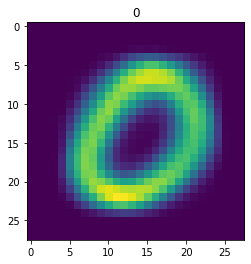

Text(0.5, 1.0, '1')

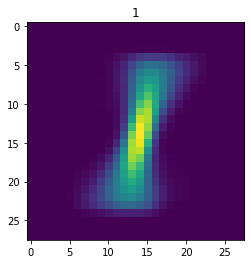

Text(0.5, 1.0, '2')

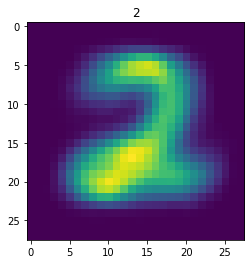

Text(0.5, 1.0, '3')

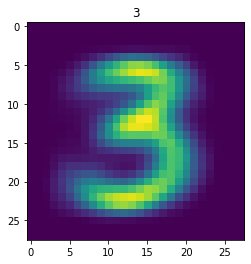

Text(0.5, 1.0, '4')

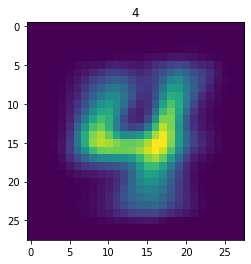

Text(0.5, 1.0, '5')

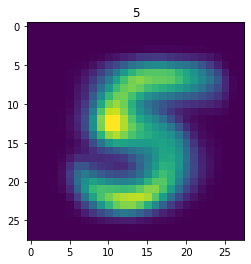

Text(0.5, 1.0, '6')

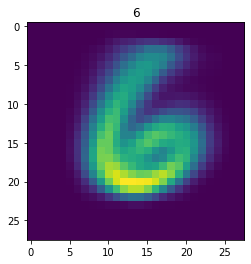

Text(0.5, 1.0, '7')

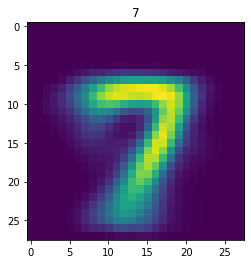

Text(0.5, 1.0, '8')

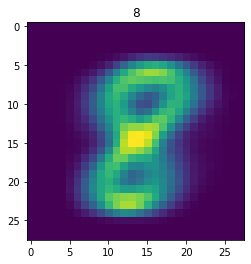

Text(0.5, 1.0, '9')

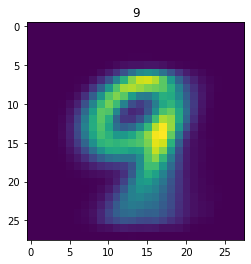

In [79]:

# plot the mean of each class
for c in labels:
    mean = model.gaussians[c]['mean']
    cov = model.gaussians[c]['var']
    plt.imshow(mean.reshape(28, 28))
    plt.title(c)
    plt.show()

In [52]:
gaussians = np.array([defaultdict(str) for index in range(4)])
#gaussians = defaultdict(str)

In [53]:
for c in range(4):
    gaussians[c] = {
        'mean': c,
        'cov': c*2,
    }

In [54]:
list(gaussians)

[{'mean': 0, 'cov': 0},
 {'mean': 1, 'cov': 2},
 {'mean': 2, 'cov': 4},
 {'mean': 3, 'cov': 6}]

In [55]:
for c in range(4):
    print(gaussians[c]['mean'])
    print(gaussians[c]['cov'])
    

0
0
1
2
2
4
3
6
